## Stock analyzer
### Lets learn insights on whether a stock can be a buy or a sell signal
### We will MA 50 day, MA 250 day, RSI to identify whether its a good time to buy or sell

In [1]:
# Fetch the yfinance stock info downloader
# Uncomment if required after 1st time install.
# !pip install yfinance pandas

In [2]:
import yfinance as yf
import pandas as pd
import os
import numpy as np

In [3]:
# Constants used
HOME="/Users/raviprabha/Desktop/github-external/ravichandraprabha/python/refresher"

## 1. Fetch Historical Stock Data

In [23]:
# Use a tickr symbol as input, get today's stock price, high, low, close, volume and save to a file.
# At the first run create this file manually for a historical info
def fetch_stock_info(tickr, window='7d', file_name=None):
    if file_name is None:
        file_name = f"{tickr}.csv"

    # Download last 7 days data
    data = yf.download(tickr, period=window, interval='1d', auto_adjust=True)

    # yf.download is returning a multi-index with tickr. Resetting it.
    # If data has a multi-index (sometimes with 'ticker'), flatten it
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)  # take only column names, not ticker

    return data
        

In [5]:
import subprocess

def is_latest_data_in_file(dt, tickr):
    count = int(subprocess.run(
        f"grep -c {dt} {tickr}.csv",
        shell=True, capture_output=True, text=True
    ).stdout.strip())
    
    return count


In [6]:
# Write output to local file
def write_to_local(df, tickr):
    file_name = f"{tickr}.csv"
    # print(os.getcwd())

    # Convert latest line in df from Timestamp('2025-11-05 00:00:00') to 2025-11-05
    latest_date = df.index[-1]
    latest_date_string = pd.Timestamp(latest_date).strftime('%Y-%m-%d')

    if not os.path.exists(file_name):
        with open(file_name, 'w') as fh:
            df.to_csv(file_name, header=True, index=True, mode='a')
    
    if not is_latest_data_in_file(latest_date_string, tickr):
        df.tail(1).to_csv(file_name, header=False, index=True, mode='a')
        
    return
        

In [7]:
def compute_rsi(df, period=14):
    # 1. Calculate daily price changes
    delta = df['Close'].diff()

    # 2. Separate gains and losses
    gain = delta.clip(lower=0)
    loss = -1 * delta.clip(upper=0)

    # 3. Calculate rolling average gains and losses
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()

    # 4. Calculate Relative Strength (RS)
    rs = avg_gain / avg_loss

    # 5. Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [8]:
def compute_kpi(df):
    # min_periods=1 ensures there are no NaN values if there is no initial data
    df['MA50'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['MA250'] = df['Close'].rolling(window=250, min_periods=1).mean()

    # Add RSI column to DataFrame
    df['RSI'] = compute_rsi(df)
    
    return df


In [9]:
def generate_signal(row, prev_rsi):
    """
    Generate trading signal based on:
    - MA50 vs MA250 (trend)
    - Price relative to MA50 / MA250
    - RSI zones
    - RSI direction (up / down)
    
    Returns dict: {'Scenario', 'Condition', 'Decision'}
    """
    scenario = None
    condition = ''
    decision = 'Hold'  # default

    rsi_direction = 'up' if row['RSI'] > prev_rsi else 'down'

    price = row['Close']
    ma50 = row['MA50']
    ma250 = row['MA250']
    rsi = row['RSI']

    # --- Scenario 1: Uptrend, Price > MA50, RSI > 70 ---
    if ma50 > ma250 and price > ma50 and rsi > 70:
        scenario = 1
        condition = 'Uptrend, price high, RSI very high'
        decision = 'Strong Sell' if rsi_direction == 'down' else 'Hold'

    # --- Scenario 2: Uptrend, Price > MA50, RSI 50-70 ---
    elif ma50 > ma250 and price > ma50 and 50 <= rsi <= 70:
        scenario = 2
        condition = 'Uptrend, price high, RSI moderate'
        decision = 'Hold'

    # --- Scenario 3: Uptrend, Price < MA50, RSI < 50 ---
    elif ma50 > ma250 and price < ma50 and rsi < 50:
        scenario = 3
        condition = 'Uptrend, price dipped, RSI weak → turning up'
        decision = 'Buy' if rsi_direction == 'up' else 'Hold'

    # --- Scenario 4: Uptrend, Price < MA50, RSI > 70 ---
    elif ma50 > ma250 and price < ma50 and rsi > 70:
        scenario = 4
        condition = 'Uptrend, price dipped, RSI high → turning down'
        decision = 'Sell' if rsi_direction == 'down' else 'Hold'

    # --- Scenario 5: Mid-trend, Price near MA50/MA250, RSI 50-70 ---
    elif abs(price - ma50)/ma50 < 0.01 or (price < ma50 and price > ma250 and 50 <= rsi <= 70):
        scenario = 5
        condition = 'Mid-trend, price near MA50, RSI moderate'
        decision = 'Hold'

    # --- Scenario 6: Mid-trend, Price < MA50 but > MA250, RSI < 50 ---
    elif price < ma50 and price > ma250 and rsi < 50:
        scenario = 6
        condition = 'Mid-trend, price low, RSI weak → turning up'
        decision = 'Buy' if rsi_direction == 'up' else 'Hold'

    # --- Scenario 7: Downtrend, Price < MA50, RSI > 70 ---
    elif ma50 < ma250 and price < ma50 and rsi > 70:
        scenario = 7
        condition = 'Downtrend, price high, RSI overbought → turning down'
        decision = 'Strong Sell' if rsi_direction == 'down' else 'Hold'

    # --- Scenario 8: Downtrend, Price < MA50, RSI 50-70 ---
    elif ma50 < ma250 and price < ma50 and 50 <= rsi <= 70:
        scenario = 8
        condition = 'Downtrend, price moderate, RSI moderate'
        decision = 'Hold'

    # --- Scenario 9: Downtrend, Price < MA50, RSI < 30 ---
    elif ma50 < ma250 and price < ma50 and rsi < 30:
        scenario = 9
        condition = 'Downtrend, price low, RSI very low → turning up'
        decision = 'Strong Buy' if rsi_direction == 'up' else 'Hold'

    # --- Scenario 10: Flat trend, Price ≈ MA50 ≈ MA250, RSI ~50 ---
    elif abs(ma50 - ma250)/ma250 < 0.01 and abs(price - ma50)/ma50 < 0.01 and 45 <= rsi <= 55:
        scenario = 10
        condition = 'Flat trend, price neutral, RSI neutral'
        decision = 'Hold'

    else:
        # Fallback
        scenario = 0
        condition = 'Unclassified scenario'
        decision = 'Hold'

    return {'Scenario': scenario, 'Condition': condition, 'Decision': decision}



In [10]:
def final_trading_decision(row_dict):
    """
    Returns the same decision from row_dict['Decision'].
    Can be extended for confidence scoring.
    """
    return row_dict['Decision']

In [11]:
def run(symbol):
    latest_data_df = fetch_stock_info(symbol)

    # Save today's data to CSV
    write_to_local(latest_data_df, symbol)

    # Load historical data
    data_df = pd.read_csv(f"{symbol}.csv")

    # Compute KPIs: RSI, MA50, MA250
    compute_kpi(data_df)
    data_df = data_df.dropna(subset=['RSI', 'MA50', 'MA250'])

    # Compute previous RSI for direction
    data_df['Prev_RSI'] = data_df['RSI'].shift(1)

    # Apply generate_signal with price + MA + RSI direction logic
    data_df['SignalInfo'] = data_df.apply(lambda row: generate_signal(row, prev_rsi=row['Prev_RSI']), axis=1)

    # Extract Scenario, Condition, Decision
    data_df['Scenario'] = data_df['SignalInfo'].apply(lambda x: x['Scenario'])
    data_df['Condition'] = data_df['SignalInfo'].apply(lambda x: x['Condition'])
    data_df['Final_Decision'] = data_df['SignalInfo'].apply(lambda x: x['Decision'])

    # Today's info
    row = data_df.iloc[-1]
    today_dt = row['Date']
    today_close = row['Close']
    today_decision = row['Final_Decision']
    today_scenario = row['Scenario']
    today_condition = row['Condition']

    decision = (
        f"Date: {today_dt}, Close: {today_close}, "
        f"Scenario: {today_scenario}, Condition: {today_condition}, "
        f"Decision: {today_decision}"
    )

    # Save decision to file
    with open(f"{symbol}_decision.txt", 'a') as fh:
        fh.write(decision + "\n")

    print(decision)
    return data_df

    

In [12]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_scenarios(df, symbol):
    """
    Plots price + MA50/MA250 and colors each point according to Scenario/Decision.
    """
    df['Date'] = pd.to_datetime(df['Date'])

    # Color map for decisions
    color_map = {
        'Strong Buy': 'green',
        'Buy': 'lime',
        'Hold': 'blue',
        'Sell': 'orange',
        'Strong Sell': 'red'
    }

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # --- Price + MA chart ---
    ax1.plot(df['Date'], df['Close'], label='Close Price', color='black')
    ax1.plot(df['Date'], df['MA50'], label='MA50', color='red', linestyle='--')
    ax1.plot(df['Date'], df['MA250'], label='MA250', color='orange', linestyle='--')

    # Plot decision markers
    for decision, color in color_map.items():
        mask = df['Final_Decision'] == decision
        ax1.scatter(df.loc[mask, 'Date'], df.loc[mask, 'Close'], 
                    color=color, label=decision, s=50, alpha=0.7)

    ax1.set_title(f'{symbol} Price + MA with Trading Signals')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # --- RSI chart ---
    ax2.plot(df['Date'], df['RSI'], label='RSI', color='purple')
    ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    ax2.set_title(f'{symbol} RSI with Signals')
    ax2.set_ylabel('RSI')
    ax2.set_xlabel('Date')
    ax2.legend()
    ax2.grid(True)

    # Format x-axis weekly
    ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()

## How to read the chart
* MA50 = Moving average for 50 days
* MA250 = Moving average for 250 days
* RSI = Relative Strength Index

| Scenario | MA Relationship / Price            | RSI Zone  | Condition Description                                | Decision    |
| -------- | ---------------------------------- | --------- | ---------------------------------------------------- | ----------- |
| 1        | MA50 > MA250, Price > MA50         | RSI > 70  | Uptrend, price high, RSI very high                   | Strong Sell |
| 2        | MA50 > MA250, Price > MA50         | RSI 50–70 | Uptrend, price high, RSI moderate                    | Hold        |
| 3        | MA50 > MA250, Price < MA50         | RSI < 50  | Uptrend, price dipped, RSI weak → turning up         | Buy         |
| 4        | MA50 > MA250, Price < MA50         | RSI > 70  | Uptrend, price dipped, RSI high → turning down       | Sell        |
| 5        | Price ≈ MA50, between MA50 & MA250 | RSI 50–70 | Mid-trend, price near MA50, RSI moderate             | Hold        |
| 6        | Price < MA50 but > MA250           | RSI < 50  | Mid-trend, price low, RSI weak → turning up          | Buy         |
| 7        | MA50 < MA250, Price < MA50         | RSI > 70  | Downtrend, price high, RSI overbought → turning down | Strong Sell |
| 8        | MA50 < MA250, Price < MA50         | RSI 50–70 | Downtrend, price moderate, RSI moderate              | Hold        |
| 9        | MA50 < MA250, Price < MA50         | RSI < 30  | Downtrend, price low, RSI very low → turning up      | Strong Buy  |
| 10       | MA50 ≈ MA250, Price ≈ MA50         | RSI ~50   | Flat trend, price neutral, RSI neutral               | Hold        |


In [13]:
df1 = run('VOO')
df1.to_csv('test_data_VOO.csv')

[*********************100%***********************]  1 of 1 completed

Date: 2025-11-07, Close: 615.28759765625, Scenario: 5, Condition: Mid-trend, price near MA50, RSI moderate, Decision: Hold


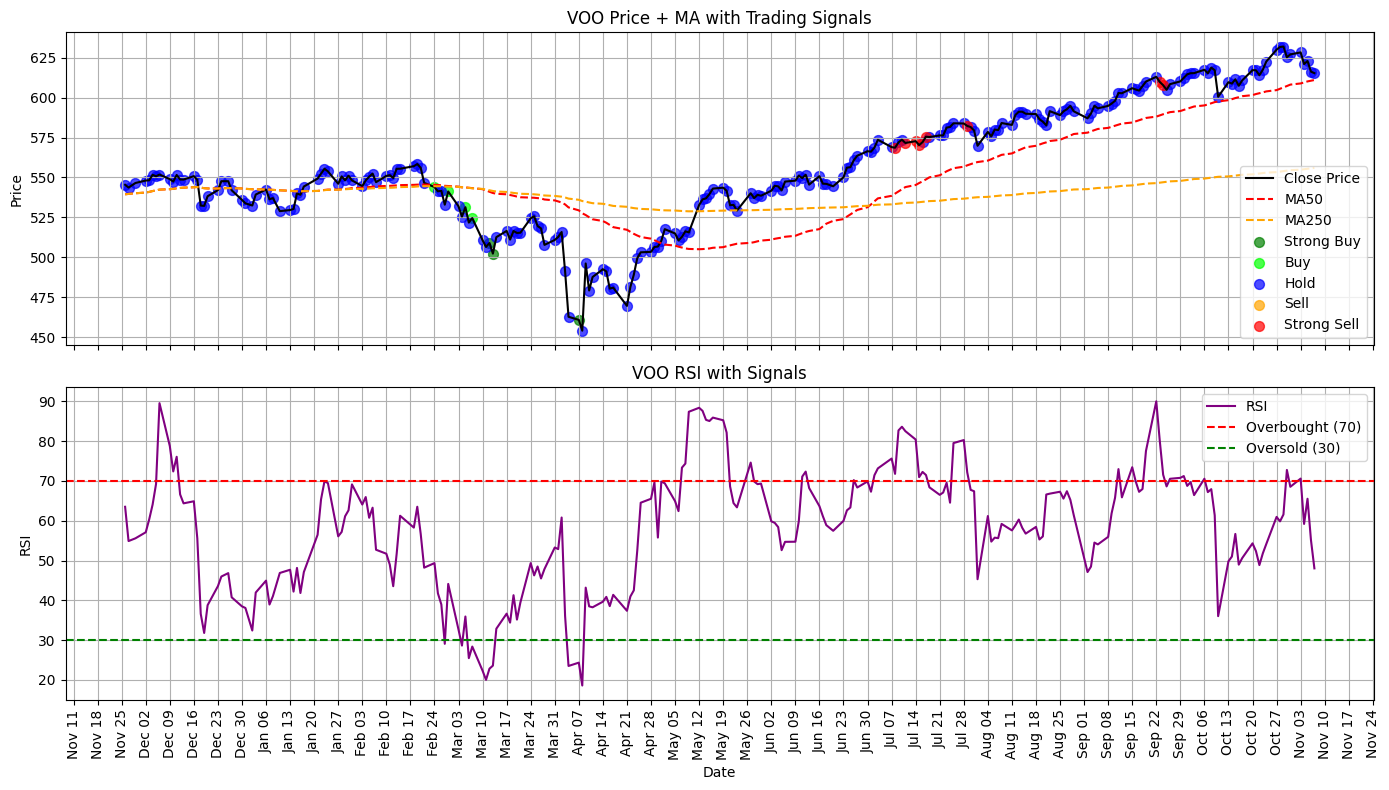

In [14]:
plot_scenarios(df1, 'VOO')

In [15]:
df2 = run('TQQQ')
df2.to_csv('test_data_TQQQ.csv')

[*********************100%***********************]  1 of 1 completed

Date: 2025-11-07, Close: 104.7699966430664, Scenario: 0, Condition: Unclassified scenario, Decision: Hold


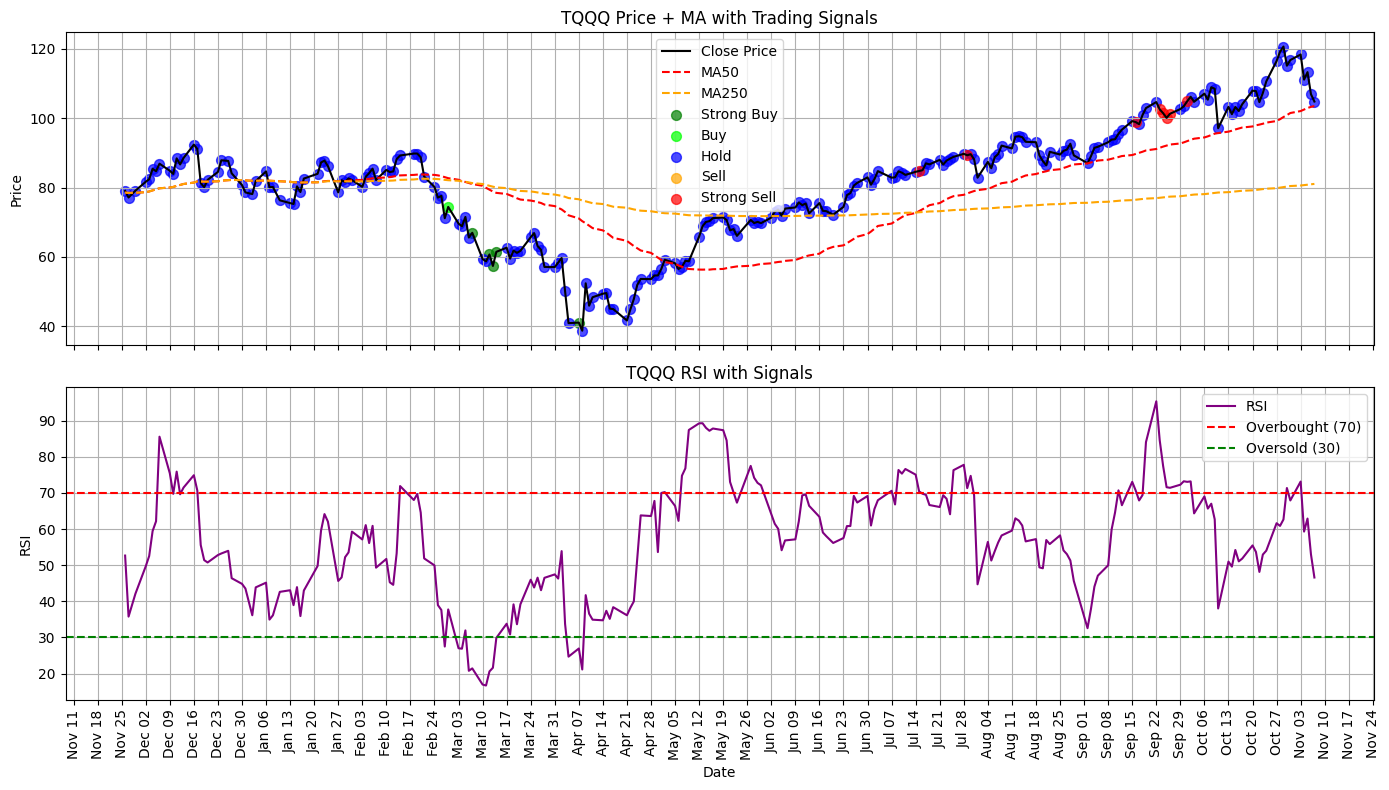

In [16]:
plot_scenarios(df2, 'TQQQ')

[*********************100%***********************]  1 of 1 completed


Date: 2025-11-07, Close: 499.05999755859375, Scenario: 2, Condition: Uptrend, price high, RSI moderate, Decision: Hold


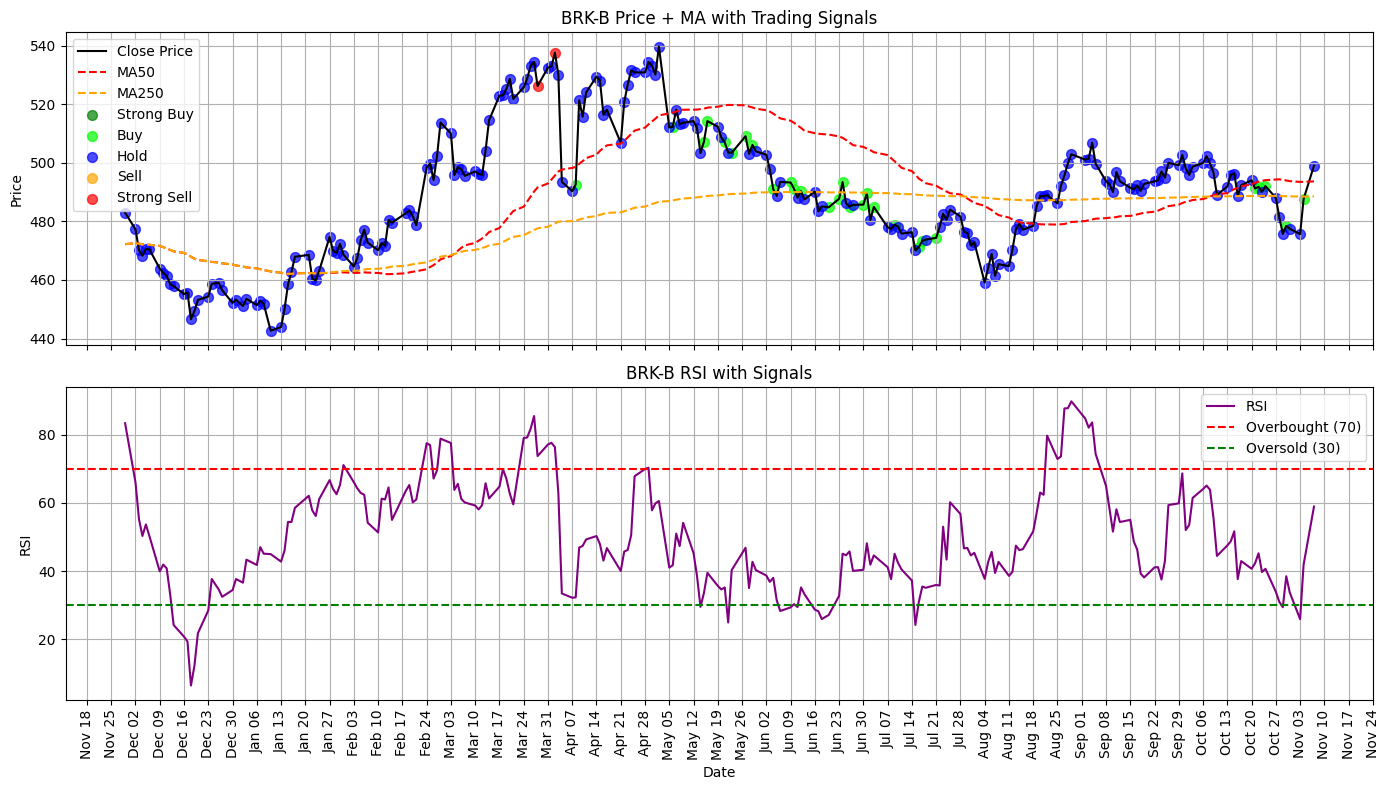

In [28]:
df3 = run('BRK-B')
df3.to_csv('test_data_BRK-B.csv')
plot_scenarios(df3, 'BRK-B')

## First time history load

In [27]:

# tickr = 'BRK-B'
# history_df = fetch_stock_info(tickr, window='1y')
# write_to_local(history_df, tickr)


[*********************100%***********************]  1 of 1 completed
